In [2]:
library(mixAK)
library(coda)
library(lme4)

Loading required package: colorspace

Loading required package: lme4

Loading required package: Matrix


### Mixture of methods including mixtures
### Arnost Komarek

### See citation("mixAK") or toBibtex(citation("mixAK")) for the best way to cite
### the package if you find it useful.





# data

In [3]:
df_fea <- read.csv("sk_feature_timescale_Fb2_eicu.csv",as.is = TRUE)
df_fea <- as.data.frame(df_fea)
df <- subset(df_fea,select=c(stay_id,time,bun,creatinine,urineoutput, crea_divide_basecrea))

fea_lst = c("bun","creatinine","urineoutput","crea_divide_basecrea")
df_y = df[,fea_lst]

ip <- getProfiles(t = "time", y = fea_lst, id = "stay_id", data = df)

# model

In [3]:
k=4 #The number of variables in the model
ran_int_status = T #calculate random intercepts and slopes. This means that for a 2 cluster solution two intercepts and two slopes will be calculated
ran_eff_num <- 2*length(k) #The number of random effects will be equal to two times the number of variables that will be used in the clustering.

mod2 <- GLMM_MCMC(y =df_y, 
                 dist = rep("gaussian",1), 
                 id = df[, "stay_id"],
                 x = list(bun="empty", creatinine="empty", urineoutput="empty", crea_divide_basecrea="empty"),
                 z = list(bun=df[, "time"], creatinine=df[, "time"], urineoutput=df[, "time"], crea_divide_basecrea=df[, "time"]),
                 random.intercept = rep(ran_int_status, ran_eff_num/2),prior.b = list(Kmax = 2),
                 nMCMC = c(burn = 50, keep = 2000, thin = 50, info = 50),
                 parallel = TRUE, PED = F);
mod2 <- NMixRelabel(mod2, type = "stephens", keep.comp.prob = TRUE)

mod3 <- GLMM_MCMC(y =df_y, 
                  dist = rep("gaussian",1), 
                  id = df[, "stay_id"],
                  x = list(bun="empty", creatinine="empty", urineoutput="empty", crea_divide_basecrea="empty"),
                  z = list(bun=df[, "time"], creatinine=df[, "time"], urineoutput=df[, "time"], crea_divide_basecrea=df[, "time"]),
                  random.intercept = rep(ran_int_status, ran_eff_num/2),prior.b = list(Kmax = 3),
                  nMCMC = c(burn = 50, keep = 2000, thin = 50, info = 50),
                  parallel = TRUE, PED = F);
mod3 <- NMixRelabel(mod3, type = "stephens", keep.comp.prob = TRUE)

mod4 <- GLMM_MCMC(y =df_y, 
                  dist = rep("gaussian",1), 
                  id = df[, "stay_id"],
                  x = list(bun="empty", creatinine="empty", urineoutput="empty", crea_divide_basecrea="empty"),
                  z = list(bun=df[, "time"], creatinine=df[, "time"], urineoutput=df[, "time"], crea_divide_basecrea=df[, "time"]),
                  random.intercept = rep(ran_int_status, ran_eff_num/2),prior.b = list(Kmax = 4),
                  nMCMC = c(burn = 50, keep = 500, thin = 50, info = 50),
                  parallel = TRUE, PED = F);
mod4 <- NMixRelabel(mod4, type = "stephens", keep.comp.prob = TRUE)

mod5 <- GLMM_MCMC(y =df_y, 
                  dist = rep("gaussian",1), 
                  id = df[, "stay_id"],
                  x = list(bun="empty", creatinine="empty", urineoutput="empty", crea_divide_basecrea="empty"),
                  z = list(bun=df[, "time"], creatinine=df[, "time"], urineoutput=df[, "time"], crea_divide_basecrea=df[, "time"]),
                  random.intercept = rep(ran_int_status, ran_eff_num/2),prior.b = list(Kmax = 5),
                  nMCMC = c(burn = 50, keep = 500, thin = 50, info = 50),
                  parallel = TRUE, PED = F);
mod5 <- NMixRelabel(mod5, type = "stephens", keep.comp.prob = TRUE)



Chain number 1
MCMC sampling started on Thu Dec 14 15:16:50 2023.
Burn-in iteration 50
Iteration 1015202530354045505560657075808590951010111112121313141415151616171718181919202050
MCMC sampling finished on Thu Dec 14 15:45:55 2023.

Chain number 1
MCMC sampling started on Thu Dec 14 15:16:50 2023.
Burn-in iteration 50
Iteration 1015202530354045505560657075808590951010111112121313141415151616171718181919202050
MCMC sampling finished on Thu Dec 14 15:45:55 2023.
MCMC Iteration (simple re-labelling) 2000
Stephens' re-labelling iteration (number of labelling changes): 1 (0)  
MCMC Iteration (simple re-labelling) 2000
Stephens' re-labelling iteration (number of labelling changes): 1 (0)  

Chain number 1
MCMC sampling started on Thu Dec 14 15:48:37 2023.
Burn-in iteration 50
Iteration 1015202530354045505560657075808590951010111112121313141415151616171718181919202050
MCMC sampling finished on Thu Dec 14 16:19:11 2023.

Chain number 1
MCMC sampling started on Thu Dec 14 15:48:37 2023.
Burn-i

# model stat

In [4]:
#THe following script is dedicated to the model assessment
Devs1 <-  list() #model deviance list
mcmc1_convergence<-list() #mcmc convergence list
analysisvars<-list();
mod_objects <- list(mod2,mod3,mod4,mod5)# some of models gathered in a list object
counter=1
for (i in 1:length(mod_objects)){
  sim=i
  mod_object <- mod_objects[[i]] #pick one simulation output (one clustering solution)
  K=mod_object$prior.b$Kmax #find number of cluster
  Devs1[[sim]] <- mod_object[["Deviance"]] #extract model deviance 
  mus_summary<-apply(NMixChainComp(mod_object, relabel = T, param = "mu_b"),2,function(x) autocorr(mcmc(x),lags = 1)); #calculate autocorrelation per mixed effect parameter. High autocorrelation suggests lack of MCMC convergence
  mus_summary1<-length(which(mus_summary>.85))/length(mus_summary) #calculate percentage of chains with bad convergence to penalize during the model assessment
  groupMed <- apply((mod_object$quant.comp.prob[["50%"]])/2, 1, which.max) #calculate median clustering
  pHPD <- HPDinterval(mcmc(mod_object$comp.prob)) #add uncertainty measures in the clustering procedure
  pHPDlower <- matrix(pHPD[, "lower"], ncol = K, byrow = TRUE) #calculate uncertainly classified observations
  pHPDupper <- matrix(pHPD[, "upper"], ncol = K, byrow = TRUE) #calculate uncertainly classified observations
  rownames(pHPDlower) <- rownames(pHPDupper) <- names(ip) #calculate uncertainly classified observations
  groupHPD <- groupMed #calculate uncertainly classified observations
  for (i in 1:K){ groupHPD[groupHPD == i & pHPDlower[, i] <= 0.5] <- K+1} #calculate uncertainly classified observations
  mcmc1_convergence<-rbind(mcmc1_convergence, c(K,mus_summary1,
                     ifelse(!is.na(match(K+1,names(table(groupHPD)))),table(groupHPD)[which(names(table(groupHPD))==K+1)],0))) #summarise the data apart from the deviance in a list object 
  print(unlist(mcmc1_convergence[counter]))
  #rm(list= ls()[!(ls() %in% c('thelist',"Devs1", "analysisvars","mcmc1_convergence","counter"))])
  counter=counter+1;
  gc();
}
#summarise all the information and give names to the quality measure outputs
mcmc1_convergence<-data.frame(mcmc1_convergence)
mcmc1_convergence[,1]<-unlist(mcmc1_convergence[,1])
mcmc1_convergence[,2]<-unlist(mcmc1_convergence[,2])
mcmc1_convergence[,3]<-unlist(mcmc1_convergence[,3])
mcmc1_convergence$deviance<-unlist(lapply(Devs1,function(x) ifelse(length(x)>1,mean(x),NA)))
mcmc1_convergence$clusternum<-mcmc1_convergence$X1
colnames(mcmc1_convergence)[2]<-"mcmc_mus_failed"
colnames(mcmc1_convergence)[3]<-"uncertainly_clustered_individuals"
mcmc_convergence <- data.frame(mcmc1_convergence[,c("clusternum","mcmc_mus_failed","uncertainly_clustered_individuals","deviance")])

#quality measure scaling function. This function normalize each quality measure between 0 and 1 so that all qualtiy measures have similar importance
scale<-function(thevar) {(((1-0)/(max(thevar)-min(thevar)))*(thevar-max(thevar))+1)}
#ordering of clustering solutions after the quality assessment. SInce the data were simulated as two clusters, the 2 cluster solution is the most optimal for the unsupervised separation of the simulated longitudinal dataset.
mcmc_convergence[order(sqrt(scale(mcmc_convergence$deviance)^2+scale(mcmc_convergence$mcmc_mus_failed)^2)),]
#schematic representation of quality assessment. The solution that is closest to 0 in the plot is the most optimal.
#The euclidean distance is used to decide the closest to zero solution accounting for deviance and MCMC chains that fail to converge
#plot(scale(mcmc_convergence$deviance), scale(mcmc_convergence$mcmc_mus_failed))
print(mcmc_convergence$clusternum)
print(scale(mcmc_convergence$deviance))

[1] 2
[1] 3
[1] 4
[1] 5
[1] 2
[1] 3
[1] 4
[1] 5


,clusternum,mcmc_mus_failed,uncertainly_clustered_individuals,deviance
,<dbl>,<dbl>,<dbl>,<dbl>
2,3,0.00000,206,555519.6
1,2,0.00000,44,556131.1
4,5,0.50000,134,702157.1
3,4,0.65625,58,702017.7


[1] 2 3 4 5
[1] 0.004169909 0.000000000 0.999049349 1.000000000


,clusternum,mcmc_mus_failed,uncertainly_clustered_individuals,deviance
,<dbl>,<dbl>,<dbl>,<dbl>
2,3,0.00000,206,555519.6
1,2,0.00000,44,556131.1
4,5,0.50000,134,702157.1
3,4,0.65625,58,702017.7


[1] 2 3 4 5
[1] 0.004169909 0.000000000 0.999049349 1.000000000


In [1]:
clusternum <- c(3,2,5,4)
mcmc_mus_failed <- c(0, 0, 0.5,0.65625)
uncertainly_clustered_individuals <- c(206, 44, 134, 58)
deviance <- c(555519.6, 556131.1, 702157.1, 702017.7)
df <- data.frame(clusternum = clusternum, mcmc_mus_failed = mcmc_mus_failed, uncertainly_clustered_individuals = uncertainly_clustered_individuals,deviance=deviance)
df

clusternum,mcmc_mus_failed,uncertainly_clustered_individuals,deviance
<dbl>,<dbl>,<dbl>,<dbl>
3,0.00000,206,555519.6
2,0.00000,44,556131.1
5,0.50000,134,702157.1
4,0.65625,58,702017.7


In [2]:
pdf("eicu_cluster_number_select.pdf")
scale<-function(thevar) {(((1-0)/(max(thevar)-min(thevar)))*(thevar-max(thevar))+1)}
df["v"] <- sqrt(scale(df$deviance)^2+scale(df$mcmc_mus_failed)^2)
df <- df[order(df$clusternum),]
plot(df$clusternum, df$v, type = "o", main = "eICU",cex=2,lwd=2, xlab = "Number of clusters", ylab = "ED(cluster means with high autocorrelation, deviance)",cex.axis = 1.5,cex.lab = 1.5, cex.main=1.8) # (cluster means with high autocorrelation, model deviance)
abline(v = 3, col = "red", lty = "longdash",cex=2, lwd=1)
text(x = 4, y = 0.05, labels = "Optimal number of clusters: 3",cex=1.5)
dev.off()
df[order(df$v),]

png 
  2

,clusternum,mcmc_mus_failed,uncertainly_clustered_individuals,deviance,v
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,0.00000,206,555519.6,0.000000000
2,2,0.00000,44,556131.1,0.004170147
3,5,0.50000,134,702157.1,1.257178932
4,4,0.65625,58,702017.7,1.413541516


# Observed longitudinal profiles by clusters

In [7]:
f_mod <- mod3

groupMean <- apply(f_mod$poster.comp.prob, 1, which.max)
pMean <- apply(f_mod$poster.comp.prob, 1, max)
print(f_mod$quant.comp.prob[["50%"]][1:3, ])
table(groupMean)

           [,1]      [,2]         [,3]
[1,] 0.47180219 0.5270643 6.963009e-04
[2,] 0.02567840 0.9742658 4.829529e-05
[3,] 0.05033506 0.9491904 4.146203e-04
           [,1]      [,2]         [,3]
[1,] 0.47180219 0.5270643 6.963009e-04
[2,] 0.02567840 0.9742658 4.829529e-05
[3,] 0.05033506 0.9491904 4.146203e-04


groupMean
  1   2   3 
423 869 125 

groupMean
  1   2   3 
423 869 125 

In [8]:
groupMed <- apply(f_mod$quant.comp.prob[["50%"]], 1, which.max)
pMed <- apply(f_mod$quant.comp.prob[["50%"]], 1, max)
#table(groupMed)
table(groupMean, groupMed)

         groupMed
groupMean   1   2   3
        1 421   2   0
        2   0 869   0
        3   1   0 124

         groupMed
groupMean   1   2   3
        1 421   2   0
        2   0 869   0
        3   1   0 124

In [9]:
#TAB <- table(df$stay_id)
#df$groupHPD <- factor(rep(groupHPD, TAB), exclude = NULL)
TAB <- table(df_fea$stay_id)
df_fea$groupHPD <- factor(rep(groupMean, TAB), exclude = NULL)
write.csv(x = df_fea, file = "./df_mixAK_fea4_C3_eicu.csv", row.names = FALSE)

In [14]:
save.image("./mixAK.RData")


# plot 

In [2]:
library(mixAK)
library(coda)
library(lme4)

Loading required package: colorspace

Loading required package: lme4

Loading required package: Matrix


### Mixture of methods including mixtures
### Arnost Komarek

### See citation("mixAK") or toBibtex(citation("mixAK")) for the best way to cite
### the package if you find it useful.





In [3]:
df_fea <- read.csv("sk_feature_timescale_Fb2_eicu.csv",as.is = TRUE)
df_fea <- as.data.frame(df_fea)
df <- subset(df_fea,select=c(stay_id,time,bun,creatinine,urineoutput, crea_divide_basecrea))

fea_lst = c("bun","creatinine","urineoutput","crea_divide_basecrea")
df_y = df[,fea_lst]

ip <- getProfiles(t = "time", y = fea_lst, id = "stay_id", data = df)

In [4]:
load("./mixAK.RData")
ip <- getProfiles(t = "time", y = c('urineoutput',  'creatinine',  "groupHPD"), id = "stay_id", data = df_fea)


In [5]:
GCOL <- rainbow_hcl(3, start = 220, end = 40, c = 50, l = 60)[c(1,2,3)]
names(GCOL) <- levels(df_fea$groupHPD)
mode(GCOL)
GCOL # 绿，红，蓝

[1] "character"

1         2         3 
"#349CB8" "#5D9F62" "#B9865F"

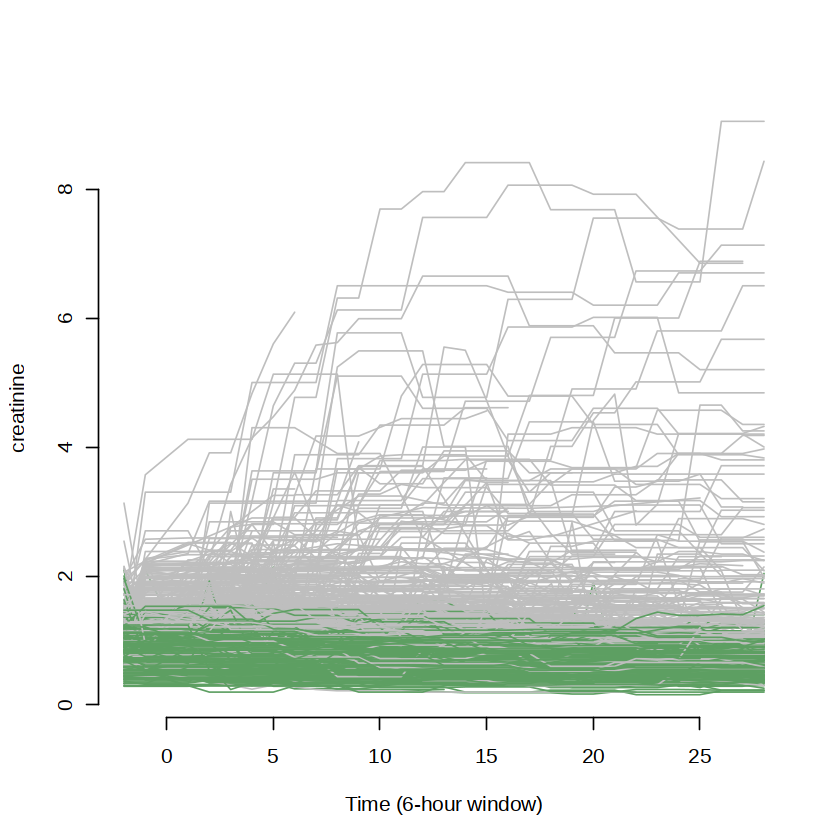

In [11]:
# 调用 plotProfiles 函数
col_lines <- c('grey', "#5D9F62", "grey")
plotProfiles(ip = ip, data = df_fea, var = "creatinine", tvar = "time", gvar = "groupHPD",
             points = FALSE,  auto.layout = TRUE, xlab = "Time (6-hour window)",col=col_lines)
             


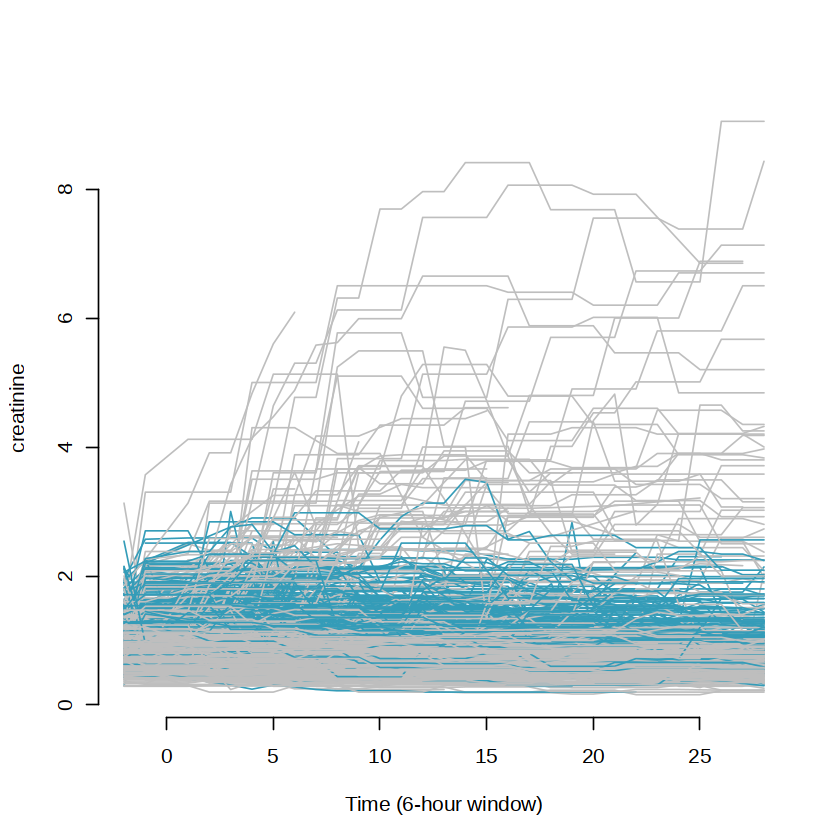

In [10]:
# 调用 plotProfiles 函数
col_lines <- c('#349CB8', "grey", "grey")
plotProfiles(ip = ip, data = df_fea, var = "creatinine", tvar = "time", gvar = "groupHPD",
             points = FALSE, auto.layout = TRUE, xlab = "Time (6-hour window)",col=col_lines) #  trans = log,
              


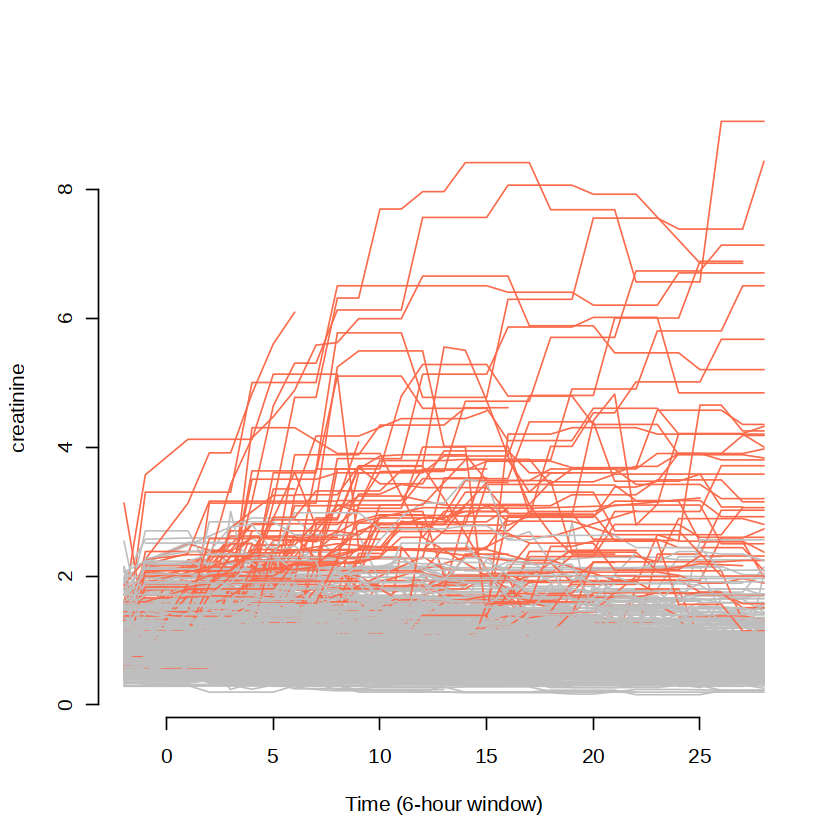

In [9]:
# 调用 plotProfiles 函数
col_lines <- c('grey', "grey", "#fb6a4a")
plotProfiles(ip = ip, data = df_fea, var = "creatinine", tvar = "time", gvar = "groupHPD",
             points = FALSE, auto.layout = TRUE, xlab = "Time (6-hour window)",col=col_lines) # trans = log,
             


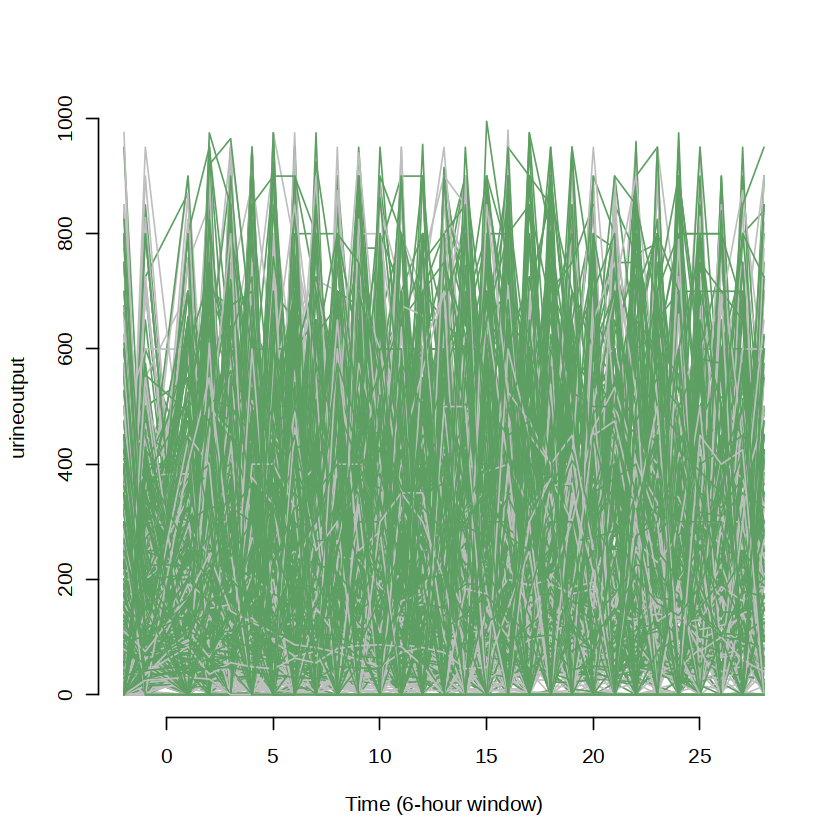

In [13]:
# 调用 plotProfiles 函数
col_lines <- c('grey', "#5D9F62", "grey")
plotProfiles(ip = ip, data = df_fea, var = "urineoutput", tvar = "time", gvar = "groupHPD",
             points = FALSE,  auto.layout = TRUE, xlab = "Time (6-hour window)",col=col_lines)
             

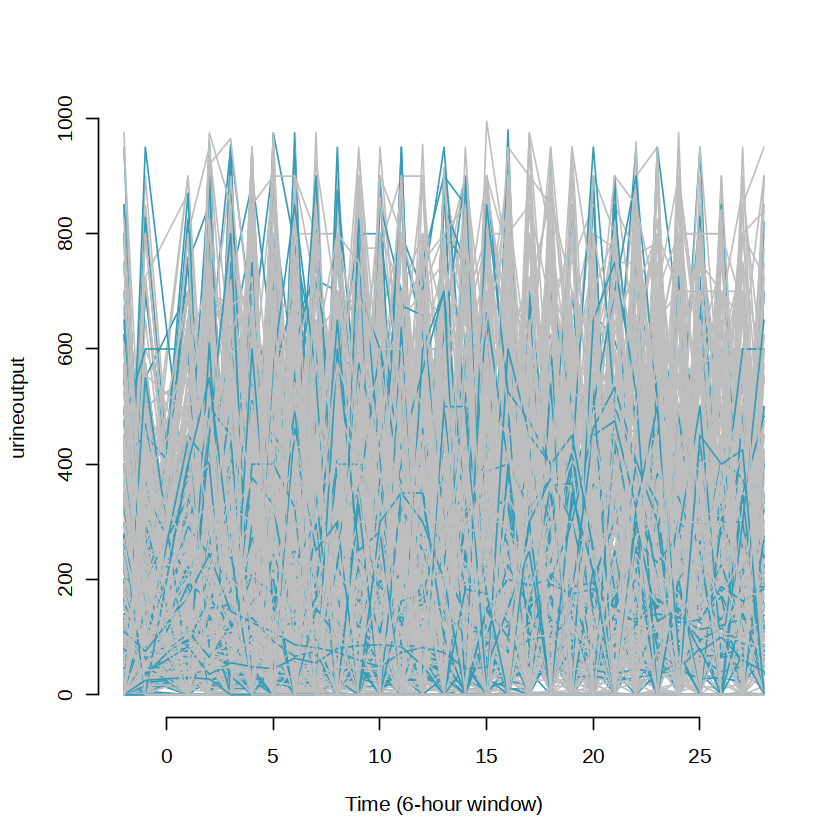

In [14]:
# 调用 plotProfiles 函数
col_lines <- c('#349CB8', "grey", "grey")
plotProfiles(ip = ip, data = df_fea, var = "urineoutput", tvar = "time", gvar = "groupHPD",
             points = FALSE, auto.layout = TRUE, xlab = "Time (6-hour window)",col=col_lines)
             


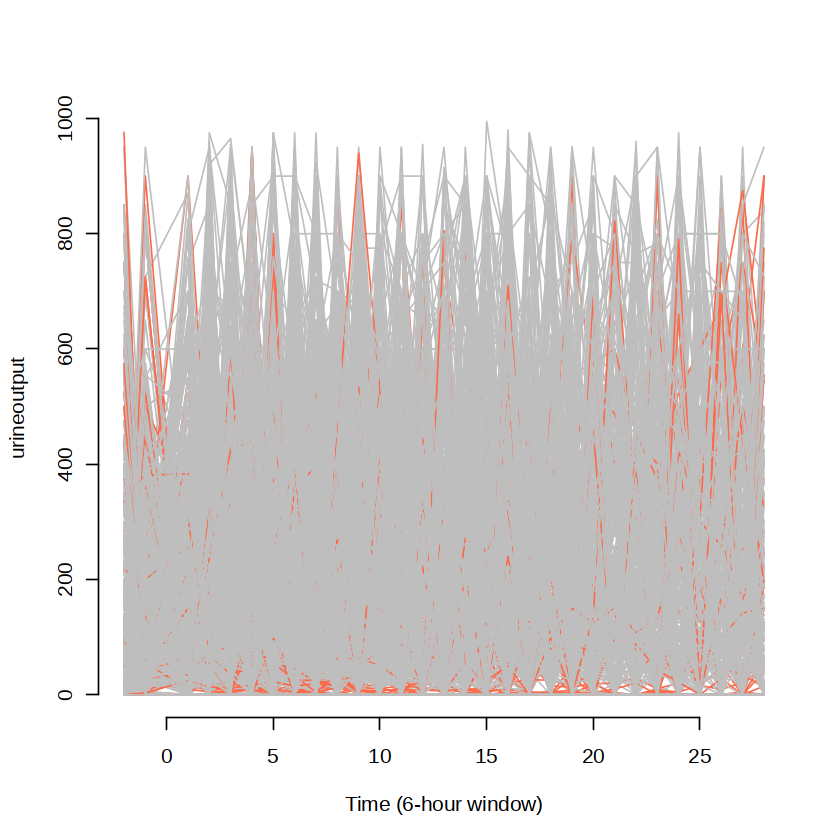

In [15]:
# 调用 plotProfiles 函数
col_lines <- c('grey', "grey", "#fb6a4a")
plotProfiles(ip = ip, data = df_fea, var = "urineoutput", tvar = "time", gvar = "groupHPD",
             points = FALSE, auto.layout = TRUE, xlab = "Time (6-hour window)",col=col_lines) # trans = log,
             


In [10]:
library(ggplot2)
col_lines <- c('#349CB8', "grey", "grey") # 替换为你想要的颜色
col_points <- c('#349CB8', "grey", "grey")  # 替换为你想要的颜色

# 创建 ggplot2 图形
my_plot = ggplot(df_fea, aes(x = time, y = creatinine, color = groupHPD)) +
  geom_line(aes(group = groupHPD), color = col_lines[1], size = 1) +
  geom_point(aes(color = groupHPD), shape = 16, size = 3) +
  scale_color_manual(values = col_points, labels = c("DR", "RR", "PW")) +
  labs(x = "Time (6-hour window)", y = "Creatinine") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),  # 调整轴刻度标签的大小
    axis.title.x = element_text(size = 14),  # 调整 x 轴标签的大小
    axis.title.y = element_text(size = 14)   # 调整 y 轴标签的大小
      ,aspect.ratio = 1
  )
ggsave("eicu_crea_DR.pdf", plot = my_plot, width = 8, height = 8)
ggsave("eicu_crea_DR.png", plot = my_plot, width = 8, height = 8, dpi = 300)

In [11]:
library(ggplot2)
col_lines <- c("grey", "#5D9F62", "grey") # 替换为你想要的颜色
col_points <- c("grey", "#5D9F62", "grey")
# 创建 ggplot2 图形
my_plot = ggplot(df_fea, aes(x = time, y = creatinine, color = groupHPD)) +
  geom_line(aes(group = groupHPD), color = col_lines[1], size = 1) +
  geom_point(aes(color = groupHPD), shape = 16, size = 3) +
  scale_color_manual(values = col_points, labels = c("DR", "RR", "PW")) +
  labs(x = "Time (6-hour window)", y = "Creatinine") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),  # 调整轴刻度标签的大小
    axis.title.x = element_text(size = 14),  # 调整 x 轴标签的大小
    axis.title.y = element_text(size = 14)   # 调整 y 轴标签的大小
      ,aspect.ratio = 1
  ) 
ggsave("eicu_crea_RR.pdf", plot = my_plot, width = 8, height = 8)
ggsave("eicu_crea_RR.png", plot = my_plot, width = 8, height = 8, dpi = 300)

In [12]:
library(ggplot2)
col_lines <- c("grey", "grey", "#fb6a4a") # 替换为你想要的颜色
col_points <- c("grey", "grey", "#fb6a4a")
# 创建 ggplot2 图形
my_plot = ggplot(df_fea, aes(x = time, y = creatinine, color = groupHPD)) +
  geom_line(aes(group = groupHPD), color = col_lines[3], size = 1) +
  geom_point(aes(color = groupHPD), shape = 16, size = 3) +
  scale_color_manual(values = col_points, labels = c("DR", "RR", "PW")) +
  labs(x = "Time (6-hour window)", y = "Creatinine") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),  # 调整轴刻度标签的大小
    axis.title.x = element_text(size = 14),  # 调整 x 轴标签的大小
    axis.title.y = element_text(size = 14)   # 调整 y 轴标签的大小
    ,aspect.ratio = 1
  ) 
ggsave("eicu_crea_PW.pdf", plot = my_plot, width = 8, height = 8)
ggsave("eicu_crea_PW.png", plot = my_plot, width = 8, height = 8, dpi = 300)

In [13]:
library(ggplot2)
col_lines <- c('#349CB8', "grey", "grey") # 替换为你想要的颜色
col_points <- c('#349CB8', "grey", "grey")  # 替换为你想要的颜色

# 创建 ggplot2 图形
my_plot = ggplot(df_fea, aes(x = time, y = urineoutput, color = groupHPD)) +
  geom_line(aes(group = groupHPD), color = col_lines[1], size = 1) +
  geom_point(aes(color = groupHPD), shape = 16, size = 3) +
  scale_color_manual(values = col_points, labels = c("DR", "RR", "PW")) +
  labs(x = "Time (6-hour window)", y = "urine output") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),  # 调整轴刻度标签的大小
    axis.title.x = element_text(size = 14),  # 调整 x 轴标签的大小
    axis.title.y = element_text(size = 14)   # 调整 y 轴标签的大小
      ,aspect.ratio = 1
  )
ggsave("eicu_uo_DR.pdf", plot = my_plot, width = 8, height = 8)
ggsave("eicu_uo_DR.png", plot = my_plot, width = 8, height = 8, dpi = 300)

In [14]:
library(ggplot2)
col_lines <- c("grey", "#5D9F62", "grey") # 替换为你想要的颜色
col_points <- c("grey", "#5D9F62", "grey")
# 创建 ggplot2 图形
my_plot = ggplot(df_fea, aes(x = time, y = urineoutput, color = groupHPD)) +
  geom_line(aes(group = groupHPD), color = col_lines[1], size = 1) +
  geom_point(aes(color = groupHPD), shape = 16, size = 3) +
  scale_color_manual(values = col_points, labels = c("DR", "RR", "PW")) +
  labs(x = "Time (6-hour window)", y = "urine output") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),  # 调整轴刻度标签的大小
    axis.title.x = element_text(size = 14),  # 调整 x 轴标签的大小
    axis.title.y = element_text(size = 14)   # 调整 y 轴标签的大小
    ,aspect.ratio = 1
  ) 
ggsave("eicu_uo_RR.pdf", plot = my_plot, width = 8, height = 8)
ggsave("eicu_uo_RR.png", plot = my_plot, width = 8, height = 8, dpi = 300)

In [15]:
library(ggplot2)
col_lines <- c("grey", "grey", "#fb6a4a") # 替换为你想要的颜色
col_points <- c("grey", "grey", "#fb6a4a")
# 创建 ggplot2 图形
my_plot = ggplot(df_fea, aes(x = time, y = urineoutput, color = groupHPD)) +
  geom_line(aes(group = groupHPD), color = col_lines[3], size = 1) +
  geom_point(aes(color = groupHPD), shape = 16, size = 3) +
  scale_color_manual(values = col_points, labels = c("DR", "RR", "PW")) +
  labs(x = "Time (6-hour window)", y = "urine output") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),  # 调整轴刻度标签的大小
    axis.title.x = element_text(size = 14),  # 调整 x 轴标签的大小
    axis.title.y = element_text(size = 14)   # 调整 y 轴标签的大小
    ,aspect.ratio = 1
  ) 
ggsave("eicu_uo_PW.pdf", plot = my_plot, width = 8, height = 8)
ggsave("eicu_uo_PW.png", plot = my_plot, width = 8, height = 8, dpi = 300)